In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import numpy as np
import random
import sys

sys.path.append('../tools')

import os

import torch

import pandas as pd
from sklearn.model_selection import train_test_split
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import pytorch_lightning.callbacks as pl_callbacks
import data_utility, annotation_utility
from models.rns_dataloader import *
from active_learning_utility import get_strategy
from active_learning_data import Data
from active_learning_net import Net
from copy import deepcopy
from models.SwaV import SwaV
from models.LSTMDownStream import SupervisedDownstream
import warnings
import pickle
warnings.filterwarnings("ignore")


C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [3]:
random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)
    # True ensures the algorithm selected by CUFA is deterministic
    torch.backends.cudnn.deterministic = True
    # torch.set_deterministic(True)
    # False ensures CUDA select the same algorithm each time the application is run
    torch.backends.cudnn.benchmark = False

import pytorch_lightning

pytorch_lightning.utilities.seed.seed_everything(seed=random_seed, workers=True)

Global seed set to 42


42

In [4]:
data_dir = "../../../user_data/"
log_folder_root = '../../../user_data/logs/'
ckpt_folder_root = '../../../user_data/checkpoints/'

In [5]:
strategy_name = 'EntropySampling'

In [6]:
nStart = 1
nEnd = 20
nQuery = 2

In [7]:
args_task = {'n_epoch': 60,
             'transform_train': True,
             'strategy_name': strategy_name,
             'transform': False,
             'loader_tr_args': {'batch_size': 4, 'num_workers': 4, 'collate_fn': collate_fn,
                                'drop_last': True, 'persistent_workers': True},
             'loader_te_args': {'batch_size': 4, 'num_workers': 4, 'collate_fn': collate_fn,
                                'drop_last': True, 'persistent_workers': True}
             }

In [8]:
# raw_annotations = pd.read_csv(data_dir + 'full_updated_anns_annotTbl_cleaned.csv')
# ids = list(np.unique(raw_annotations[raw_annotations['descriptions'].notnull()]['HUP_ID']))
# # ids = list(np.unique(raw_annotations['HUP_ID']))
#
# data_import = data_utility.read_files(path=data_dir+'rns_data', path_data=data_dir+'rns_raw_cache', patientIDs=ids,
#                                       verbose=True)  # Import data with annotation

In [9]:
# data_list = os.listdir(data_dir+'rns_test_cache')
# print(data_list)
data_list = ['HUP047.npy', 'HUP084.npy', 'HUP096.npy', 'HUP109.npy', 'HUP121.npy', 'HUP129.npy', 'HUP131.npy',
             'HUP137.npy', 'HUP147.npy', 'HUP156.npy', 'HUP159.npy', 'HUP182.npy', 'HUP197.npy', 'HUP199.npy',
             'RNS026.npy', 'RNS029.npy']
# data_list = os.listdir(data_dir+'rns_test_cache')[1:]

# data_list = ['HUP182.npy',   'HUP129.npy',   'HUP109.npy', 'HUP156.npy', 'HUP096.npy', 'RNS026.npy',  'HUP159.npy']
# data_list = ['RNS026.npy', 'HUP159.npy', 'HUP129.npy', 'HUP096.npy', 'HUP182.npy']
train_data, train_label, test_data, test_label, train_index, test_index = get_data_by_episode(data_list, split=0.8)
# data, label,_,_ = get_data(data_list, split=1)
# train_data, test_data, train_label, test_label = sklearn.model_selection.train_test_split(data, label, test_size=0.8, random_state=42)

print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

16it [00:05,  2.81it/s]

(992,)
(992,)
(270,)
(270,)


In [10]:
X_train = np.concatenate(train_data)
y_train = np.concatenate(train_label)
X_test = np.concatenate(test_data)
y_test = np.concatenate(test_label)
index_train = np.concatenate(train_index)
index_test = np.concatenate(test_index)
seq_len_train = np.array([y.shape[0] for y in train_label])
seq_len_test = np.array([y.shape[0] for y in test_label])

In [11]:
n_pool = len(train_data)
n_test = len(test_data)

NUM_INIT_LB = int(nStart * n_pool / 100)
NUM_QUERY = int(nQuery * n_pool / 100) if nStart != 100 else 0
NUM_ROUND = int((int(nEnd * n_pool / 100) - NUM_INIT_LB) / NUM_QUERY) if nStart != 100 else 0
if NUM_QUERY != 0:
    if (int(nEnd * n_pool / 100) - NUM_INIT_LB) % NUM_QUERY != 0:
        NUM_ROUND += 1

print(NUM_INIT_LB)
print(NUM_QUERY)
print(NUM_ROUND)

9
19
10


In [12]:
dataset = Data(X_train, y_train, X_test, y_test, seq_len_train, seq_len_test, RNS_Active_by_episode_LSTM, args_task)

In [13]:
# swav = SwaV().load_from_checkpoint(
#     ckpt_folder_root + 'rns_swav_50_12/rns_swav-epoch=82-swav_loss=2.58204.ckpt')
# model = SupervisedDownstream(swav.backbone)
# # initialize model and save the model state
# modelstate = deepcopy(model.state_dict())
# device = "cuda" if torch.cuda.is_available() else "cpu"
# 
# net = Net(model, args_task, device, ckpt_folder_root='rns_active', log_folder_root='rns_active')

In [14]:
from active_learning_waal import Net_WAAL, WAAL, Classifier, Discriminator

swav = SwaV().load_from_checkpoint(
    ckpt_folder_root + 'rns_swav_50_12/rns_swav-epoch=82-swav_loss=2.58204.ckpt')
model = WAAL(swav.backbone, Classifier(2048), Discriminator(2048))
# initialize model and save the model state
modelstate = deepcopy(model.state_dict())
device = "cuda" if torch.cuda.is_available() else "cpu"
handler_joint = Handler_joint
net = Net_WAAL(model, args_task, device, handler_joint, ckpt_folder_root='rns_active', log_folder_root='rns_active')

In [15]:
from active_learning_lpl import Classifier, LossNet, LPL, Backbone
swav = SwaV().load_from_checkpoint(
    ckpt_folder_root + 'rns_swav_50_12/rns_swav-epoch=82-swav_loss=2.58204.ckpt')
model = LPL(Backbone(swav.backbone), Classifier(2048), LossNet())
# initialize model and save the model state
modelstate = deepcopy(model.state_dict())
device = "cuda" if torch.cuda.is_available() else "cpu"

net = Net(model, args_task, device, ckpt_folder_root='rns_active', log_folder_root='rns_active')

In [16]:
strategy = get_strategy(strategy_name, dataset, net, None, args_task, rns_data=True)

In [17]:
trainer = pl.Trainer(accelerator='gpu',
                     devices=1,
                     precision=16,)

strategy.net.trainer = trainer

MisconfigurationException: No supported gpu backend found!

In [18]:
from sklearn.model_selection import KFold

def get_accuracy_scores(pred_raw, target, out, episode_out, episode_target):

    kf = KFold(n_splits=100, shuffle=True, random_state=42)
    accuracies = []
    f1_scores = []
    auc_scores = []
    episode_acc = []
    episode_f1s = []
    for train_ind, test_ind in kf.split(out):
        pred_split, target_split, pred_raw_split = out[test_ind],target[test_ind],m(pred_raw.float())[:,1][test_ind]
        acc = sklearn.metrics.accuracy_score(pred_split, target_split)
        f1_score = sklearn.metrics.f1_score(pred_split, target_split, pos_label=1, average='macro')
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(target_split, pred_raw_split, pos_label=1)
        auc = sklearn.metrics.auc(fpr, tpr)
        accuracies.append(acc)
        f1_scores.append(f1_score)
        auc_scores.append(auc)
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    for train_ind, test_ind in kf.split(episode_out):
        episode_pred_split, episode_target_split = episode_out[test_ind], episode_target[test_ind]
        episode_acc.append(sklearn.metrics.accuracy_score(episode_pred_split,episode_target_split))
        episode_f1s.append(sklearn.metrics.f1_score(episode_pred_split,episode_target_split, pos_label=1, average='macro'))
    return accuracies, f1_scores, auc_scores, episode_acc, episode_f1s

In [19]:
import torch.nn as nn
import sklearn
for strategy_name in [ 'LossPredictionLoss']:
    result_final = {}
    for rd in range(0, NUM_ROUND+1):
    # for rd in [10]:
        print('round ' + str(rd))
        log_file_name = log_folder_root + 'rns_active/active_logs_' + strategy_name + '/logger_round_' + str(
            rd) + '/version_0/metrics.csv'
        logs = pd.read_csv(log_file_name)
        # max_ind = logs['val_acc'].argmax()
        # max_row = logs.iloc[max_ind]
        sinds = np.argsort(list(logs['val_acc']))[::-1]
        ckpt_directory = ckpt_folder_root + 'rns_active/active_checkpoints_' + strategy_name
        ckpt_files = os.listdir(ckpt_directory)
        
        n = np.min((len(ckpt_files),3))
        
        selected_ind = sinds[~np.isnan(logs['val_acc'][sinds])][:n]
        
        result_list = []
        for s_idx in selected_ind:
            max_row = logs.iloc[s_idx]
            load_file_name = strategy_name + '_round_' + str(rd) + '-step=' + str(int(max_row['step']+1))
            print(load_file_name)
            
            ind = next((i for i, s in enumerate(ckpt_files) if load_file_name in s), None)
            print(ind, ckpt_files[ind])
            # strategy.net.net = strategy.net.net.load_from_checkpoint(ckpt_directory + '/' + ckpt_files[ind], backbone=swav.backbone)
            # strategy.net.net = strategy.net.net.load_from_checkpoint(ckpt_directory + '/' + ckpt_files[ind],
            #                               net_fea=swav.backbone,
            #                               net_clf=Classifier(2048),
            #                               net_dis=Discriminator(2048))
            strategy.net.net = strategy.net.net.load_from_checkpoint(ckpt_directory + '/' + ckpt_files[ind],
                                          net_fea=Backbone(swav.backbone),
                                          net_clf=Classifier(2048),
                                          net_lpl=LossNet())
            with open(log_folder_root + 'rns_active_selected/' + strategy_name + '/' + 'selected_indices.pkl', 'rb') as f:
            # Load the content of the file into a Python object
                selected_inds = pickle.load(f)
            
            q_idxs = np.array(selected_inds[rd])
            
            strategy.update(q_idxs)
            
            _, unlabeled_data = strategy.dataset.get_train_data_unaugmented()
            predictions = strategy.net.run_prediction(unlabeled_data)
            output_list = []
            seq_len_list = []
            target_list = []
            emb_list = []
            m = nn.Softmax(dim=1)
            for pred, y, emb, emb_t, seq_len in predictions:
                output_list.append(pred)
                seq_len_list.append(seq_len)
                target_list.append(y)
                emb_list.append(emb)
            
            target = torch.concat(target_list)
            emb = torch.vstack(emb_list)
            pred_raw = torch.vstack(output_list).float()
            seq_len_out = torch.tensor([item for sublist in seq_len_list for item in sublist])
            probs = m(pred_raw)
            out = torch.argmax(pred_raw, dim=1)
            unlabeled_idxs, _ = strategy.dataset.get_unlabeled_data()
            
            pred_label_split = strategy.dataset.combine_window_to_episode(out, seq_len_train, ~strategy.dataset.labeled_idxs)
            test_label_split = strategy.dataset.combine_window_to_episode(target, seq_len_train, ~strategy.dataset.labeled_idxs)
            episode_out = torch.tensor([np.sign(tl.sum()) for tl in pred_label_split])
            episode_target = torch.tensor([np.sign(tl.sum()) for tl in test_label_split])
            
            result_list.append(get_accuracy_scores(pred_raw[unlabeled_idxs], target[unlabeled_idxs], out[unlabeled_idxs], episode_out, episode_target))

        
        result_final[rd] = result_list
    
    # np.save('save_acc/'+ strategy_name + '.npy', result_final)

round 0
LossPredictionLoss_round_0-step=60
2 LossPredictionLoss_round_0-step=60-train_loss=0.01181.ckpt


AttributeError: 'NoneType' object has no attribute 'predict'

In [ ]:
import torch.nn as nn
import sklearn
result_final = {}
for rd in range(0, NUM_ROUND+1):
# for rd in [10]:
    print('round ' + str(rd))
    # log_file_name = log_folder_root + 'rns_active/active_logs_' + strategy_name + '/logger_round_' + str(
    #     rd) + '/version_0/metrics.csv'
    # logs = pd.read_csv(log_file_name)
    # max_ind = logs['val_acc'].argmax()
    # max_row = logs.iloc[max_ind]
    # sinds = np.argsort(list(logs['val_acc']))[::-1]
    # ckpt_directory = ckpt_folder_root + 'rns_active/active_checkpoints_' + strategy_name
    # ckpt_files = os.listdir(ckpt_directory)
    
    # n = np.min((len(ckpt_files),3))
    # 
    # selected_ind = sinds[~np.isnan(logs['val_acc'][sinds])][:n]
    

            # max_row = logs.iloc[s_idx]
    # load_file_name = strategy_name + '_round_' + str(rd) + '-step=' + str(int(max_row['step']+1))
    # print(load_file_name)
    # 
    # ind = next((i for i, s in enumerate(ckpt_files) if load_file_name in s), None)
    # print(ind, ckpt_files[ind])
    # strategy.net.net = strategy.net.net.load_from_checkpoint(ckpt_directory + '/' + ckpt_files[ind], backbone=swav.backbone)
    
    with open(log_folder_root + 'rns_active_selected/' + strategy_name + '/' + 'selected_indices.pkl', 'rb') as f:
    # Load the content of the file into a Python object
        selected_inds = pickle.load(f)
    
    q_idxs = np.array(selected_inds[rd])
    
    strategy.update(q_idxs)
            
#             _, unlabeled_data = strategy.dataset.get_train_data_unaugmented()
#             predictions = strategy.net.run_prediction(unlabeled_data)
#             output_list = []
#             seq_len_list = []
#             target_list = []
#             emb_list = []
#             m = nn.Softmax(dim=1)
#             for pred, y, emb, emb_t, seq_len in predictions:
#                 output_list.append(pred)
#                 seq_len_list.append(seq_len)
#                 target_list.append(y)
#                 emb_list.append(emb)
#             
#             target = torch.concat(target_list)
#             emb = torch.vstack(emb_list)
#             pred_raw = torch.vstack(output_list).float()
#             seq_len_out = torch.tensor([item for sublist in seq_len_list for item in sublist])
#             probs = m(pred_raw)
#             out = torch.argmax(pred_raw, dim=1)
#             unlabeled_idxs, _ = strategy.dataset.get_unlabeled_data()
#             
#             pred_label_split = strategy.dataset.combine_window_to_episode(out, seq_len_train, ~strategy.dataset.labeled_idxs)
#             test_label_split = strategy.dataset.combine_window_to_episode(target, seq_len_train, ~strategy.dataset.labeled_idxs)
#             episode_out = torch.tensor([np.sign(tl.sum()) for tl in pred_label_split])
#             episode_target = torch.tensor([np.sign(tl.sum()) for tl in test_label_split])
#             
#             result_list.append(get_accuracy_scores(pred_raw[unlabeled_idxs], target[unlabeled_idxs], out[unlabeled_idxs], episode_out, episode_target))
#         except:
#             continue
#     
#     result_final[rd] = result_list
# 
# np.save('save_acc/'+ strategy_name + '.npy', result_final)

In [ ]:
rd = 7
print('round ' + str(rd))
log_file_name = log_folder_root + 'rns_active/active_logs_' + strategy_name + '/logger_round_' + str(
    rd) + '/version_0/metrics.csv'
logs = pd.read_csv(log_file_name)
max_ind = logs['val_acc'].argmax()
max_row = logs.iloc[max_ind]
sinds = np.argsort(list(logs['val_acc']))[::-1]
ckpt_directory = ckpt_folder_root + 'rns_active/active_checkpoints_' + strategy_name
ckpt_files = os.listdir(ckpt_directory)

# n = np.min((len(ckpt_files),3))
# 
# selected_ind = sinds[~np.isnan(logs['val_acc'][sinds])][:n]
# 
# result_list = []
# for s_idx in selected_ind:
#     try:
#         max_row = logs.iloc[s_idx]
load_file_name = strategy_name + '_round_' + str(rd) + '-step=' + str(int(max_row['step']+1))
print(load_file_name)

ind = next((i for i, s in enumerate(ckpt_files) if load_file_name in s), None)
print(ind, ckpt_files[ind])
strategy.net.net = strategy.net.net.load_from_checkpoint(ckpt_directory + '/' + ckpt_files[ind], backbone=swav.backbone)

with open(log_folder_root + 'rns_active_selected/' + strategy_name + '/' + 'selected_indices.pkl', 'rb') as f:
# Load the content of the file into a Python object
    selected_inds = pickle.load(f)

q_idxs = np.array(selected_inds[rd])

strategy.update(q_idxs)

_, unlabeled_data = strategy.dataset.get_train_data_unaugmented()
predictions = strategy.net.run_prediction(unlabeled_data)


In [ ]:
import torch.nn as nn
output_list = []
seq_len_list = []
target_list = []
emb_list = []
m = nn.Softmax(dim=1)
for pred, y, emb, emb_t, seq_len in predictions:
    output_list.append(pred)
    seq_len_list.append(seq_len)
    target_list.append(y)
    emb_list.append(emb)

target = torch.concat(target_list)
emb = torch.vstack(emb_list)
pred_raw = torch.vstack(output_list).float()
seq_len_out = torch.tensor([item for sublist in seq_len_list for item in sublist])
probs = m(pred_raw)
out = torch.argmax(pred_raw, dim=1)
unlabeled_idxs, _ = strategy.dataset.get_unlabeled_data()

pred_label_split = strategy.dataset.combine_window_to_episode(out, seq_len_train, ~strategy.dataset.labeled_idxs)
test_label_split = strategy.dataset.combine_window_to_episode(target, seq_len_train, ~strategy.dataset.labeled_idxs)
episode_out = torch.tensor([np.sign(tl.sum()) for tl in pred_label_split])
episode_target = torch.tensor([np.sign(tl.sum()) for tl in test_label_split])

In [ ]:
valid_ids = np.arange(992)[np.array([not any(list(bl)) for bl in strategy.dataset.combine_window_to_episode(strategy.dataset.labeled_idxs, seq_len_train)])]

In [23]:
torch.vstack((episode_out,episode_target))[:,valid_ids]

NameError: name 'episode_out' is not defined

In [20]:
from matplotlib import pyplot as plt
def get_continuous_data(data):
    return np.vstack([data[:,:,4].flatten(),data[:,:,13].flatten(),data[:,:,22].flatten(),data[:,:,31].flatten()])

def plot_high_light(label):
    label_start = np.where(np.diff(label) == 1)[0]
    label_end = np.where(np.diff(label) == -1)[0]
    label_start, label_end = check_consistent(label_start,label_end, len(label))
    return label_start, label_end

def check_consistent(start, end, total_len):
    if len(start) != len(end):
        if len(start)>0:
            end = [total_len]
        elif len(end)>0:
            start = [0]
    return start, end

def plot_data(data, labels = None, dr=0.5):
    color_list = ["yellow", 'royalblue']
    n_samples, n_rows = data.shape[1], data.shape[0]
    h, w = n_rows * 2, 10
    y_tick_offsets = (np.arange(n_rows) * dr)[::-1] 
    plt.figure(figsize=(w, h))
    ax = plt.axes()
    eeg_data = data + y_tick_offsets[:, np.newaxis]
    time_domain = np.repeat(np.arange(data.shape[1])[:,np.newaxis]/249,4,1)
    plt.plot(time_domain, eeg_data.T, 'k', linewidth=0.5)
    for j, label in enumerate(labels):
        if label is not None:
            label_start, label_end= plot_high_light(label)
            if len(label_start)>0:
                for i in range(len(label_start)):
                    # print(label_start,label_end)
                    plt.axvspan(label_start[i], label_end[i], color=color_list[j], alpha=0.3)
    
    plt.yticks(eeg_data.mean(1))
    ax.set_yticklabels(["Ch1", "Ch2", "Ch3", "Ch4"])
    plt.grid(axis='x')
    plt.xlabel('Time (s)')
    plt.show()
    
def combine_window_to_episode(data, seq_len, index=None):
    cum_sum_index = np.cumsum(seq_len)
    cum_sum_index = np.insert(cum_sum_index, 0, 0)

    assert len(data) == cum_sum_index[-1]

    data_out = [None] * (len(cum_sum_index) - 1)

    for i in range(1, len(cum_sum_index)):
        start_index, end_index = cum_sum_index[i - 1], cum_sum_index[i]
        episode_data = data[start_index:end_index]

        if index is None:
            out = episode_data
        else:
            episode_labeled = index[start_index:end_index]
            out = episode_data[episode_labeled]

        if len(out) > 0:
            data_out[i - 1] = out

    data_out = [segment for segment in data_out if segment is not None]

    return np.array(data_out, dtype=object)



In [21]:
pred_label = combine_window_to_episode(out,seq_len_out)

NameError: name 'out' is not defined

In [22]:
for idsample_id in valid_ids[100:200]:
    print(sample_id)
    plot_data(get_continuous_data(train_data[sample_id]),[pred_label[sample_id],train_label[sample_id]])


NameError: name 'valid_ids' is not defined

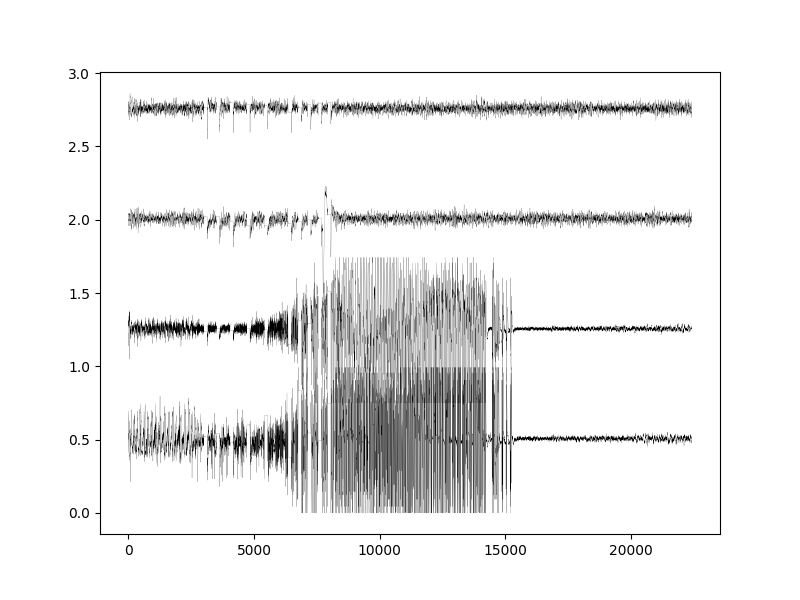

In [23]:
example_data = get_continuous_data(train_data[268])

dr= 0.75
n_samples, n_rows = example_data.shape[1], example_data.shape[0]
h, w = n_rows * 1.5, 8

y_tick_offsets = (np.arange(n_rows) * dr)[::-1]

plt.figure(figsize=(w, h))

eeg_data = example_data + y_tick_offsets[:, np.newaxis]

plt.plot(eeg_data.T, 'k', linewidth=0.1)
# plt.savefig("example_rns.svg", format="svg")
plt.show()

In [25]:
example_data.shape

(4, 22410)

In [27]:
np.save('rns_data.npy',example_data)

In [30]:
train_data[268].shape

(90, 249, 36)

In [147]:
class RNS_Active_by_episode_LSTM(Dataset):
    def __init__(self, data, label, transform=True, astensor=True):
        self.data = data
        self.label = label
        self.transform = transform

        self.length = len(self.data)

        if astensor:
            self.augmentation = T.Compose([
                T.ToPILImage(),
                # T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST),
                T.RandomApply([T.ColorJitter()], p=0.5),
                T.RandomApply([T.GaussianBlur(kernel_size=(3, 3))], p=0.5),
                T.RandomInvert(p=0.2),
                T.RandomPosterize(4, p=0.2),
                T.ToTensor()
            ])

            self.totensor = T.Compose([
                T.ToPILImage(),
                # T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST),
                T.ToTensor()
            ])
        else:
            self.augmentation = T.Compose([
                T.ToPILImage(),
                # T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST),
                T.RandomApply([T.ColorJitter()], p=0.5),
                T.RandomApply([T.GaussianBlur(kernel_size=(3, 3))], p=0.5),
                T.RandomInvert(p=0.2),
                T.RandomPosterize(4, p=0.2),
            ])

            self.totensor = T.Compose([
                T.ToPILImage(),
                # T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST),
            ])

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        data_arr = self.data[index]
        label_arr = self.label[index]
        # print(data_arr.shape)

        data_arr_out = []

        concat_len = data_arr[0].shape[1] / 4
        channel_index = np.arange(4)
        if self.transform:
            np.random.shuffle(channel_index)
        channel_index = channel_index * concat_len + (concat_len - 1) / 2
        channel_index = np.repeat(channel_index, concat_len)
        concate_len_1 = (concat_len - 1) / 2
        a_repeat = np.arange(-concate_len_1, concate_len_1 + 1)[np.newaxis].T
        base_repeat = np.repeat(a_repeat, 4, axis=1).T.flatten()
        channel_index = channel_index + base_repeat
        

        for i, data in enumerate(data_arr):
            data = data[:,channel_index.astype(int)]
            data = torch.from_numpy(data).clone()
            # data = data.repeat(3, 1, 1)

            if self.transform:
                data = self.augmentation(data)
            else:
                data = self.totensor(data)
            data_arr_out.append(data)

        data_arr_out = torch.stack(data_arr_out)

        return data_arr_out, torch.from_numpy(label_arr).to(dtype=torch.long), None

In [236]:
dt = RNS_Active_by_episode_LSTM([train_data[268]],[train_label[268]],transform=True)
dataloader = torch.utils.data.DataLoader(
    dt,
    batch_size=1,
    collate_fn=collate_fn,
    shuffle = True
)

In [237]:

print(augmentation.size())

torch.Size([90, 1, 249, 36])


In [238]:
resize = T.Resize((249, 36), interpolation=T.InterpolationMode.NEAREST)

In [241]:
import matplotlib
matplotlib.use('cairo')
plt.figure()

for i in range(10):
    augmentation = next(iter(dataloader))[0]
    example_data = get_continuous_data(augmentation[i*9:(i+1)*9].squeeze(1))
    
    dr= 0.75
    n_samples, n_rows = example_data.shape[1], example_data.shape[0]
    h, w = n_rows * 1.5, 8
    # plt.figure()
    y_tick_offsets = (np.arange(n_rows) * dr)[::-1]
    
    eeg_data = example_data + y_tick_offsets[:, np.newaxis]

    plt.plot(np.arange(i*3000,i*3000+eeg_data.shape[1]), eeg_data.T, 'k', linewidth=0.1)
plt.savefig("example_rns_augmentation.svg", format="svg")
plt.show()

131856 134096


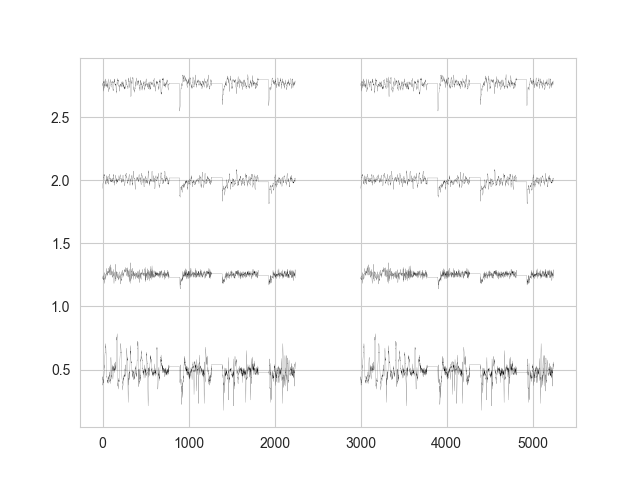

In [234]:
i=1
plt.figure()
example_data = get_continuous_data(augmentation[i*9:(i+1)*9].squeeze(1))
    
dr= 0.75
n_samples, n_rows = example_data.shape[1], example_data.shape[0]
h, w = n_rows * 1.5, 8
# plt.figure()
y_tick_offsets = (np.arange(n_rows) * dr)[::-1]

eeg_data = example_data + y_tick_offsets[:, np.newaxis]



print(np.arange(index,index+eeg_data.shape[1]).min(),np.arange(index,index+eeg_data.shape[1]).max())
plt.plot(eeg_data.T, 'k', linewidth=0.1)
      
index = index+eeg_data.shape[1]+6000
plt.show()

In [205]:
eeg_data.T.shape

(2241, 4)

In [188]:
augmentation[i*9:(i+1)*9].squeeze(1).shape

torch.Size([9, 249, 36])

In [94]:
[resize(augmentation[i]) for i in range(len(augmentation))][0].shape

torch.Size([3, 249, 36])

In [176]:
eeg_data.shape

(4, 2241)

In [ ]:
,[pred_label[sample_id],train_label[sample_id]]

In [102]:
pred_label[sample_id].shape[0]*249

22410

In [121]:
for id in [71,82,90 ,149, 502]:
    df = pd.DataFrame()
    df['i'] = np.repeat(np.arange(85111)[np.cumsum(seq_len_out)[id]:np.cumsum(seq_len_out)[id+1]],249)
    df['ch_1'] = get_continuous_data(train_data[id])[0]
    df['ch_2'] = get_continuous_data(train_data[id])[1]
    df['ch_3'] = get_continuous_data(train_data[id])[2]
    df['ch_4'] = get_continuous_data(train_data[id])[3]
    df['true_label'] = np.repeat(train_label[id],249)
    df['pred_label'] = np.repeat(pred_label[id],249)
    df.to_csv('output_data/bad_example/' + str(id) + '.csv')

In [119]:
np.cumsum(seq_len_out)[268]

tensor(23933)

In [114]:
pd.read_pickle('output_data/embedding_space_metrics.pkl').to_csv('output_data/embedding_space_metrics.csv')

In [ ]:
71 82 90 149 502

In [24]:
empty_dict = {}

In [20]:
result_temp = result_final

In [25]:
for k in result_temp.keys():
    empty_dict[k] = result_temp[k]

In [26]:
for k in result_temp_2.keys():
    empty_dict[k] = result_temp_2[k]

In [27]:
for k in result_final.keys():
    empty_dict[k] = result_final[k]

In [28]:
empty_dict.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [29]:
result_final = empty_dict

In [22]:
result_temp_2 = result_final

In [ ]:
unlabeled_idxs

In [ ]:
[print(len(ls)) for ls in strategy.dataset.combine_window_to_episode(out, seq_len_train, ~strategy.dataset.labeled_idxs)]

In [ ]:
np.where(strategy.dataset.labeled_idxs == True)

In [ ]:
import torch.nn as nn
import sklearn
for rd in range(1, NUM_ROUND + 1):
    print('round ' + str(rd))
    log_file_name = log_folder_root + 'rns_active/active_logs_' + strategy_name + '/logger_round_' + str(
        rd) + '/version_0/metrics.csv'
    logs = pd.read_csv(log_file_name)
    max_ind = logs['val_acc'].argmax()
    max_row = logs.iloc[max_ind]
    ckpt_directory = ckpt_folder_root + 'rns_active/active_checkpoints_' + strategy_name
    ckpt_files = os.listdir(ckpt_directory)
    load_file_name = strategy_name + '_round_' + str(rd) + '-step=' + str(int(max_row['step']+1))
    print(load_file_name)

    ind = next((i for i, s in enumerate(ckpt_files) if load_file_name in s), None)
    print(ind, ckpt_files[ind])
    strategy.net.net = strategy.net.net.load_from_checkpoint(ckpt_directory + '/' + ckpt_files[ind], backbone=swav.backbone)

    with open(log_folder_root + 'rns_active_selected/' + strategy_name + '/' + 'selected_indices.pkl', 'rb') as f:
    # Load the content of the file into a Python object
        selected_inds = pickle.load(f)
    
    # selected_ind_list = []
    # for items in selected_inds.items():
    #     selected_ind_list.append(np.array(items[1]))
    q_idxs = np.array(selected_inds[rd])
    
    # with open(log_folder_root + 'rns_active_selected/' + strategy_name + '/' + 'selected_indices.pkl', 'wb') as f:
    #     pickle.dump(selected_inds, f)
# Now you can use the dictionary object as usual
    strategy.update(q_idxs)
    
    _, unlabeled_data = strategy.dataset.get_train_data_unaugmented()
    predictions = strategy.net.run_prediction(unlabeled_data)
    output_list = []
    seq_len_list = []
    target_list = []
    emb_list = []
    m = nn.Softmax(dim=1)
    for pred, y, emb, emb_t, seq_len in predictions:
        output_list.append(pred)
        seq_len_list.append(seq_len)
        target_list.append(y)
        emb_list.append(emb)

    target = torch.concat(target_list)
    emb = torch.vstack(emb_list)
    pred_raw = torch.vstack(output_list).float()
    seq_len_out = torch.tensor([item for sublist in seq_len_list for item in sublist])
    probs = m(pred_raw)
    out = torch.argmax(pred_raw, dim=1)
    unlabeled_idxs, _ = strategy.dataset.get_unlabeled_data()
    f1_score = sklearn.metrics.f1_score(target[unlabeled_idxs],out[unlabeled_idxs])

    print(f1_score)

#     strategy.net.round = rd
#     strategy.net.net.load_state_dict(modelstate)
#     torch.cuda.empty_cache()
#     strategy.train()
#     torch.cuda.empty_cache()

In [ ]:
unlabeled_idxs, _ = strategy.dataset.get_unlabeled_data()

In [ ]:
clf_report = sklearn.metrics.classification_report(torch.argmax(pred_raw, dim=1), target, digits=6)

print(f"Classification Report : \n{clf_report}")

In [ ]:
f1_score = sklearn.metrics.f1_score(target,out)

In [ ]:
f1_score